In [122]:
from IPython.display import Audio
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as numpy
import csv
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import math

In [134]:
def preprocess_data(data_sets):
    print('Starting to process entries...')
    training_data = []
    hasGone = 0
    for data_set in data_sets:
        averages, peak_widths, wavelengths, std_dev = preprocess_row(data_set)
        training_data.append([averages, peak_widths, wavelengths, std_dev])
        if (hasGone == 0):
            hasGone = 1
    print('Complete')
    return training_data

def preprocess_row(data_set):
    data_set = abs(data_set)
    peak_buffer = numpy.array([])
    valley_counter = 0
    REQUIRED_PEAK_DIFF = 3
    REQUIRED_VALLEY_DIFF = 100
    PERCENTAGE_BASE_SAMPLES = .8
    TO_BEAT_BASE_VAL = 2
    
#     Gets lower area of array to get a baseline that spikes will need to beat
    base = numpy.average(numpy.sort(data_set)[0: math.floor(len(data_set) * .8)])
    std_dev = numpy.std(data_set) * 3
    averages = numpy.array([])
    peak_widths = numpy.array([])
    wavelengths = numpy.array([])
    for entry in data_set:
        if (entry > base * TO_BEAT_BASE_VAL):
            if (len(peak_buffer) == 0):
                if (valley_counter < REQUIRED_VALLEY_DIFF):
                    continue
                wavelengths = numpy.append(wavelengths, valley_counter)
                valley_counter = 0
            peak_buffer = numpy.append(peak_buffer, entry)
        elif(len(peak_buffer) != 0):
            if (len(peak_buffer) < REQUIRED_PEAK_DIFF):
                continue
            averages = numpy.append(averages, numpy.mean(peak_buffer))
            peak_widths = numpy.append(peak_widths, len(peak_buffer))
            peak_buffer = numpy.array([])
        else:
            valley_counter+=1
    
    return averages, peak_widths, wavelengths, std_dev
    print('Average Peak height:', averages)
    print('Peak_width:', peak_widths)
    print('Wavelength:', wavelengths)
    print(len(averages))
    print(len(peak_widths))
    print(len(wavelengths))
    print(len(data_set))


arr3d = numpy.array([[[1],[2],[3]],[[2],[3],[4]],[[3],[4],[5]]])
numpy.append(arr3d, numpy.atleast_3d([[7],[9], [11]]), axis=3)

In [123]:
a = numpy.array([1,3,5,2])
a = numpy.sort(a)
a[0: math.floor(len(a)*.8)]

array([1, 2, 3])

In [129]:
file_label_arr = numpy.array([])
audio_arr = []
maxLen = 0

# Reads .csv file to get all the data set names
with open('../audio_files/dataset_b_names.csv', newline='') as f:
    reader = csv.reader(f)
#     Next skips the header info
    next(reader)
    for row in reader:
#         Has all the replaces because for some reason the .csv and the file names are slightly different
        file_name = row[1].replace('Btraining_','').replace('_','__',2).replace('__','_',1)
#         Gets audio from given file name
        audio = tfio.audio.AudioIOTensor('../audio_files/' + file_name)
#         Processes the audio
        audio_slice = audio[100:]
        audio_tensor = tf.squeeze(audio_slice, axis=[-1])
        audio_tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
#         Put in array
        audio_arr.append(audio_tensor.numpy())
        file_label_arr = numpy.append(file_label_arr, False if row[2] == 'normal' else True)
#         Keep track of longest audio file
        if (audio_tensor.shape[0] > maxLen):
            maxLen = audio_tensor.shape[0]

In [80]:
# Sets all the values to have the same shape by padding any missing values with 0's
audio_arr = numpy.array(audio_arr)
equal_size_audio_arr = []

for row in audio_arr:
    result = numpy.zeros(maxLen)
    result[:row.shape[0]] = row
    equal_size_audio_arr.append(result)

    
# training_set, training_answer, train_test_split(X, y, test_size=0.3, random_state=0)
training_set = numpy.array(equal_size_audio_arr[::2])
testing_set = numpy.array(equal_size_audio_arr[1::2])
training_answer = numpy.array(file_label_arr[::2])
testing_answer = numpy.array(file_label_arr[1::2])
print(training_set)

[[ 0.00021362  0.00344849  0.00140381 ...  0.          0.
   0.        ]
 [ 0.00027466  0.00231934  0.00570679 ...  0.          0.
   0.        ]
 [-0.00894165 -0.00384521 -0.0118103  ...  0.          0.
   0.        ]
 ...
 [-0.01831055 -0.01745605 -0.01290894 ...  0.          0.
   0.        ]
 [ 0.04217529  0.04714966  0.03756714 ...  0.          0.
   0.        ]
 [ 0.0045166   0.00653076  0.01245117 ...  0.          0.
   0.        ]]


In [130]:
processed_data = preprocess_data(audio_arr)

Starting to process entries...
Complete


[array([ 0.3607822 ,  0.25098267,  0.55196082,  0.47237578,  0.23652431,
       -0.07189941,  0.24760284, -0.21802775,  0.23628065]), array([18., 10., 23., 21.,  7.,  6., 20.,  3.,  9.]), array([ 556., 3330., 2995., 2978., 3329., 1301., 1197., 1544., 1234.]), 0.21596232801675797]
My data
[9, 0.2296202341422979, 13.0, 2051.5555555555557, 1025.8311655662026, 0.21596232801675797]
0.0


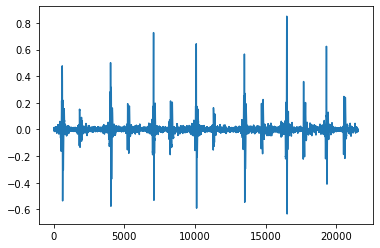

In [137]:
num = len(processed_data) -1
print(processed_data[num])
plt.figure()
plt.plot(audio_arr[num])

# print(len(processed_data[num][0]))
# print(numpy.mean(processed_data[num][0]))
# print(numpy.mean(processed_data[num][1]))
# print(numpy.mean(processed_data[num][2]))
# print(processed_data[num][3])
# print(file_label_arr[num])

post_data = []
i = 0
for data in processed_data:
    sample_lengths = len(data[0])
    i+=1
    if(sample_lengths == 0):
        post_data.append([0,0,0,0,0,data[3]])
        continue
    
    sample_average_height = numpy.mean(data[0])
    sample_average_peak_width = numpy.mean(data[1])
    sample_average_wavelength = numpy.mean(data[2])
    sample_wavelength_dev = numpy.std(data[2])
    sample_dev = data[3]
    post_data.append([sample_lengths, sample_average_height, sample_average_peak_width, 
                                                     sample_average_wavelength, sample_wavelength_dev, sample_dev])
    
print("My data")
print(post_data[num])
print(file_label_arr[num])
# for data in processed_data:
#     print(processed_data[num][3])
#     print(file_label_arr[num])
#     num+=1
    
# for num in [200,201,202,100,50,60,70,80]:
#     plt.figure()
#     plt.plot(audio_arr[num])
#     print(file_label_arr[num])
#     print(processed_data[num][0])

In [132]:
X = numpy.array(post_data)
y = file_label_arr

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)



SVC(kernel='linear')

In [133]:
y_pred = svclassifier.predict(X_train)

print(confusion_matrix(y_train,y_pred))
print(classification_report(y_train,y_pred))

[[145  11]
 [ 53  40]]
              precision    recall  f1-score   support

         0.0       0.73      0.93      0.82       156
         1.0       0.78      0.43      0.56        93

    accuracy                           0.74       249
   macro avg       0.76      0.68      0.69       249
weighted avg       0.75      0.74      0.72       249



In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, input_dim=maxLen, activation='relu', kernel_initializer='he_uniform'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(
    training_set,
    training_answer,
    epochs=8,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(testing_set, testing_answer),
    steps_per_epoch=20
)

Epoch 1/8
20/20 [==============================] - 1s 26ms/step - loss: 0.6851 - accuracy: 0.6026 - val_loss: 0.6469 - val_accuracy: 0.6731
Epoch 2/8
20/20 [==============================] - 0s 17ms/step - loss: 0.4114 - accuracy: 0.8782 - val_loss: 0.6292 - val_accuracy: 0.6859
Epoch 3/8
20/20 [==============================] - 0s 17ms/step - loss: 0.2843 - accuracy: 0.9295 - val_loss: 0.6271 - val_accuracy: 0.6923
Epoch 4/8
20/20 [==============================] - 0s 16ms/step - loss: 0.1995 - accuracy: 0.9615 - val_loss: 0.6369 - val_accuracy: 0.6795
Epoch 5/8
20/20 [==============================] - 0s 16ms/step - loss: 0.1443 - accuracy: 0.9808 - val_loss: 0.6489 - val_accuracy: 0.6923
Epoch 6/8
20/20 [==============================] - 0s 16ms/step - loss: 0.1040 - accuracy: 0.9808 - val_loss: 0.6574 - val_accuracy: 0.6987
Epoch 7/8
20/20 [==============================] - 0s 16ms/step - loss: 0.0788 - accuracy: 0.9872 - val_loss: 0.6746 - val_accuracy: 0.6859
Epoch 8/8
20/20 [===

In [15]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(testing_set, testing_answer, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(testing_set)
count = 0
for pred in predictions:
    print("pred: %s   actual: %s" %(pred, testing_answer[count]))
    count+=1

# The test accuracy is pretty low and the training accuracy is pretty high,
# see: https://datascience.stackexchange.com/questions/29893/high-model-accuracy-vs-very-low-validation-accuarcy

Evaluate on test data
2/2 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.6795
test loss, test acc: [0.6850961446762085, 0.6794871687889099]
Generate predictions for 3 samples
pred: [0.0671854]   actual: 1.0
pred: [0.4937521]   actual: 1.0
pred: [0.39151993]   actual: 1.0
pred: [0.18542069]   actual: 1.0
pred: [0.13046494]   actual: 1.0
pred: [0.08501202]   actual: 1.0
pred: [0.7246413]   actual: 1.0
pred: [0.23580372]   actual: 1.0
pred: [0.2929523]   actual: 1.0
pred: [0.56868726]   actual: 1.0
pred: [0.0689224]   actual: 1.0
pred: [0.10663229]   actual: 1.0
pred: [0.60426784]   actual: 1.0
pred: [0.18050423]   actual: 1.0
pred: [0.25335822]   actual: 1.0
pred: [0.8460628]   actual: 1.0
pred: [0.4945447]   actual: 1.0
pred: [0.67798823]   actual: 1.0
pred: [0.37604415]   actual: 1.0
pred: [0.18080688]   actual: 1.0
pred: [0.08590844]   actual: 1.0
pred: [0.49949616]   actual: 1.0
pred: [0.3683842]   actual: 1.0
pred: [0.5001268]   actual: 1.0
pred: [0.5566

In [43]:
encoder = LabelEncoder()
encoder.fit(training_answer)
encoded_Y = encoder.transform(training_answer)
encoded_Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [47]:
def create_baseline():
    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(60, input_dim=60, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_baseline(), epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
result = cross_val_score(estimator, training_set, encoded_Y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

TypeError: cannot pickle '_thread.RLock' object